# **Task \#4 B**: Machine Learning MC886/MO444
##**Natural Language Processing (NLP)**##

In [ ]:
print('Tobias Conran Zorzetto' + ' 166214')
print('Victor Costa Dominguite' + ' 245003')

Tobias Conran Zorzetto 166214
Victor Costa Dominguite 245003


## Objective:

There are two main objectives of this notebook: you can either fine-tunning a BERT model to sentiment analysis or fine-tunning a T5 model to perform translation English to Portuguese.

**You can choose which task to perform. The BERT activity is relatively easy and should take less time compared to the T5 task. However, fine-tuning these models require time. Therefore, it is recommended to test the models on a small dataset (such as one batch), to ensure the functions are working correctly. Once confirmed, you can proceed to train the models on the entire dataset.**

**If you complete both tasks, you will earn extra points.**
**Obs: In this work, you can use scikit-learn, PyTorch and HuggingFace API.**

## **Sentiment Analisys**

Sentiment analysis is a task in natural language processing that involves determining the sentiment expressed in a given text, classifying it as positive, negative, or neutral. It helps analyze people's opinions and emotions from text data, enabling businesses to understand customer feedback, monitor brand reputation, and make informed decisions.

In this notebook, we will use the IMDB Dataset, which is widely used in the field of natural language processing and sentiment analysis. It comprises a large collection of movie reviews from the IMDB website, with each review labeled as either positive or negative based on the sentiment expressed in the text.

![bert_model](https://drive.google.com/uc?export=view&id=1rWKk7K5-0MX8EkjPeRZTaG7byFQuD6Cx)

BERT (Bidirectional Encoder Representations from Transformers) is a state-of-the-art deep learning model for natural language processing (NLP). It is based on the Transformer architecture and is pre-trained on a large corpus of text data. BERT is designed to understand the context and meaning of words in a sentence by considering both the left and right context, enabling it to capture intricate language patterns. It has achieved remarkable results across various NLP tasks, including text classification, named entity recognition, question answering, and has significantly advanced the field of NLP.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download Dependencies

In [ ]:
%%time
!wget -nc -q http://files.fast.ai/data/aclImdb.tgz
!tar -xzf aclImdb.tgz
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.3 MB/s eta 0:00:00
CPU times: user 167 ms, sys: 24.7 ms, total: 191 ms
Wall time: 28.2 s


In [ ]:
import os
import copy
import torch
import random
import numpy as np
import seaborn as sns

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
from torch import nn, optim

### Parameters

In [ ]:
params = {
    'bert_version': "google/bert_uncased_L-4_H-256_A-4",
    # There are multiple versions of BERT available at the following links:
    # https://huggingface.co/google/bert_uncased_L-12_H-768_A-12
    # https://huggingface.co/bert-base-uncased
    # You can explore these links to access different versions of BERT.

    'batch_size': 32,
    'learning_rate': 1e-4, # Choose a learning rate between 1e-4 and 1e-5
    'max_length': 300,     # The maximum length of the sentence (can be adjusted)
    'epochs': 5,        # Choose a value between 1 and 5 (or alternatively, use early stopping)
}

In [ ]:
# Important: Fix seeds so we can replicate results
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


### Load data

Here we are loading the data. For training, we will use 20k samples, 5k samples for validation, and 25k samples for testing.

In [ ]:
max_valid = 5000

def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos  = load_texts('aclImdb/test/pos')
x_test_neg  = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test  = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test  = [True] * len(x_test_pos)  + [False] * len(x_test_neg)

c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = zip(*c)

x_valid = x_train[-max_valid:]
y_valid = y_train[-max_valid:]
x_train = x_train[:-max_valid]
y_train = y_train[:-max_valid]

print('\nFirst three train samples:')
for i, (source, target) in enumerate(zip(x_train[:3], y_train[:3])):
  print(f"{i}: Input: {source}\n   Target: {'positive' if target else 'negative'}\n")

print('-'*200)
print('\nFirst three valid samples:')
for i, (source, target) in enumerate(zip(x_valid[:3], y_valid[:3])):
  print(f"{i}: Input: {source}\n   Target: {'positive' if target else 'negative'}\n")

print('-'*200)
print(f'Train size: {len(x_train)}')
print(f'Valid size: {len(x_valid)}')
print(f'Test size: {len(x_test)}')


First three train samples:
0: Input: I have seen Dolemite and also (Avenging) Disco Godfather, two other fine works of the blaxploitation canon from our friend Rudy Ray Moore. But this film, The Human Tornado (aka Dolemite 2) will always hold a special place in my heart. For sheer goofiness, lack of skill in film production, and absolute enthusiasm (frankly a little too much), The Human Tornado cannot be topped.<br /><br />The opening scene sets the tone. Our old pal Dolemite is shacking up with a white woman, when some racist local cops raid the house for no good reason, and wouldn't you know it! The woman in bed with ol' Dole is none other than the sheriff's wife. Her cry when she sees him: "He made me do it!" Dolemite's cry: "&$*@$ are you for real???" Subtlety was never his strong point.<br /><br />Highlights? The cameo by a very young Ernie Hudson (of Ghostbusters fame), the continuity errors (characters looking one way in one shot, and another in the next, Dolemite's suit changi

### Tokenizer

To use text as input for a deep learning model, we first need to tokenize each sentence based on a set of rules. After tokenization, each token is assigned a correlated index, creating a feature vector. This vector is then utilized by the model to train and update the weights. Here is an example demonstrating how the BERT tokenizer works:

![bert_tokenizer](https://drive.google.com/uc?export=view&id=11LioDFis0JE3ghr672PEIeaAxZO42gUL)

Initially, the input sentence is divided into tokens predetermined by the BERT tokenizer. Next, the BertTokenizer introduces two special tokens: CLS and SEP. CLS represents sentence start for tasks like classification, while SEP indicates sentence separation for boundary detection within a document. Additionally, to ensure sentences are of equal length, the tokenizer employ the PAD token for each input.

Finally, each token is converted into a predetermined index for BERT input. This indexing enables the Bert model to train and update its weights effectively.

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data   = data
        self.labels = torch.Tensor(labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        item = {key: value[index] for key, value in self.data.items()}
        item['labels'] = self.labels[index]
        return item

In [ ]:
%%time
tokenizer = BertTokenizerFast.from_pretrained(params['bert_version'], disable_tqdm=False)

## TOKENIZE
train_encodings = tokenizer(list(x_train), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
valid_encodings = tokenizer(list(x_valid), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
test_encodings  = tokenizer(list(x_test),  truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])

## DATASET
train_dataset = IMDBDataset(data=train_encodings, labels=y_train)
valid_dataset = IMDBDataset(data=valid_encodings, labels=y_valid)
test_dataset  = IMDBDataset(data=test_encodings, labels=y_test)

## DATALOADER
train_loader = DataLoader(dataset=train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=1)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=params['batch_size'], num_workers=1)
test_loader  = DataLoader(dataset=test_dataset, batch_size=params['batch_size'], num_workers=1)

CPU times: user 1min 15s, sys: 1.12 s, total: 1min 16s
Wall time: 51.2 s


### Useful functions

**Note:** The following functions are provided as suggestions. You are free to modify and create your own functions, classes, or code. Feel free to customize!

**If the batch does not fit in memory, use gradient accumulation.**

**Hint 1:** Example of gradient accumalation in PyTorch: https://kozodoi.me/blog/20210219/gradient-accumulation.

**Hint 2:** If preferred, you can utilize the [Trainer](https://huggingface.co/docs/transformers/training) from Hugging Face for assistance.

In [ ]:
def train(criterion, optimizer):

    # batch accumulation parameter
    accum_iter = 4
    idx = 0
    correct_predictions = 0
    # loop through enumaretad batches
    for batch_idx, loader in enumerate(train_loader):

        input_ids = loader["input_ids"].to(device)
        attention_mask = loader["attention_mask"].to(device)
        labels = loader["labels"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        # passes and weights update
        with torch.set_grad_enabled(True):

            # forward pass
            _, preds = torch.max(outputs.logits, dim=1)
            loss  = criterion(outputs.logits, labels)

            # normalize loss to account for batch accumulation
            loss = loss / accum_iter

            # backward pass
            loss.backward()

            correct_predictions += torch.sum(preds == labels)
            idx+=1
            if(batch_idx % params['batch_size'] == 0):
                print("trained", batch_idx)

            # weights update
            if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_loader)):
                optimizer.step()
                optimizer.zero_grad()

    acc = correct_predictions.double() / (params['batch_size']*idx)

    return loss, acc

def evaluate(criterion,optimizer):
    # batch accumulation parameter
  correct_predictions = 0
  accum_iter = 4
  idx = 0
  # loop through enumaretad batches
  for batch_idx, loader in enumerate(valid_loader):

      # extract inputs and labels
      input_ids = loader["input_ids"].to(device)
      attention_mask = loader["attention_mask"].to(device)
      labels = loader["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      # passes and weights update
      with torch.set_grad_enabled(False):

          # forward pass
          _, preds = torch.max(outputs.logits, dim=1)
          loss  = criterion(outputs.logits, labels)

          # normalize loss to account for batch accumulation
          loss = loss / accum_iter

          correct_predictions += torch.sum(preds == labels)
          idx+=1

  acc = correct_predictions/(params['batch_size']*idx)

  print("accuracy:", acc)

  return loss, acc

In [ ]:
class EarlyStopping():
  '''
    Early stopping prevents overfitting by stopping the training process when
    the model's performance on a validation set starts to worsen.

    Parameters:
    -----------
    patience  : int
      Tolerance for no improvement.
    min_delta : float
      Minimum change required.
  '''

  def __init__(self, patience=1, min_delta=0.0001):
    self.patience = patience
    self.counter = 0
    self.best_score = None
    self.best_model_wts = None
    self.min_delta = min_delta

  def __call__(self, model, val_loss):
    score = -val_loss

    if self.best_score is None:
      self.best_score = score
      self.best_model_wts = copy.deepcopy(model.state_dict())
      return False

    elif score < self.best_score + self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        return True
    else:
      self.best_score = score
      self.best_model_wts = copy.deepcopy(model.state_dict())
      self.counter = 0
    return False

### Train the BERT model

**Note:** The following functions are provided as suggestions. You are free to modify and create your own functions, classes, or code. Feel free to customize!

**Hint 1:** See the [BertForSequenceClassification](https://huggingface.co/docs/transformers/v4.30.0/en/model_doc/bert#transformers.BertForSequenceClassification) documentation for more information.

**Hint 2:** Instead of saving information by epoch, you can save it by step. A step corresponds to a single update of the model's weights based on a mini-batch of data, while an epoch represents a complete pass through the entire training dataset. The number of steps is determined by the batch size and the total number of training examples, whereas the number of epochs is a user-defined hyperparameter.

**Hint 3:** BERT adapts very well to classification problems, so in just 3 or 4 epochs, the results are already acceptable (**BERT Base**). If the results are still not good, check the learning rate.

**Hint 4:** Conduct small tests, such as using only one batch, to train and verify the functionality of the training and evaluation functions. After confirming their effectiveness, proceed to train the model with all the dataset.

In [ ]:
model = BertForSequenceClassification.from_pretrained(params['bert_version'])
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
#scheduler = None # https://pytorch.org/docs/stable/optim.html (not mandatory)

early_stopping = EarlyStopping()

history = {'train_loss': [], 'valid_loss': [], 'train_acc':[], 'valid_acc':[]}

for epoch in tqdm(range(params['epochs']), desc='Training'):
  train_loss, train_acc = train(criterion,optimizer)
  valid_loss, valid_acc = evaluate(criterion, optimizer)

  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)

  history['valid_loss'].append(valid_loss)
  history['valid_acc'].append(valid_acc)

  if early_stopping(model, valid_loss): break

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

Training:   0%|          | 0/5 [00:00<?, ?it/s]

trained 0
trained 64
trained 128
trained 192
trained 256
trained 320
trained 384
trained 448
trained 512
trained 576
accuracy: tensor(0.8424, device='cuda:0')
trained 0
trained 64
trained 128
trained 192
trained 256
trained 320
trained 384
trained 448
trained 512
trained 576
accuracy: tensor(0.8678, device='cuda:0')
trained 0
trained 64
trained 128
trained 192
trained 256
trained 320
trained 384
trained 448
trained 512
trained 576
accuracy: tensor(0.8700, device='cuda:0')
trained 0
trained 64
trained 128
trained 192
trained 256
trained 320
trained 384
trained 448
trained 512
trained 576
accuracy: tensor(0.8726, device='cuda:0')
trained 0
trained 64
trained 128
trained 192
trained 256
trained 320
trained 384
trained 448
trained 512
trained 576
accuracy: tensor(0.8668, device='cuda:0')


### Evaluation of the model

In [ ]:
## Save Best Model Weights and history
path = 'drive/MyDrive'


torch.save(early_stopping.best_model_wts, f'{path}/weights_bert.pth')


train_loss_cpu = []
valid_loss_cpu = []
train_acc_cpu = []
valid_acc_cpu = []

for data in history['train_loss']:
  train_loss_cpu.append(data.data.cpu())
for data in history['valid_loss']:
  valid_loss_cpu.append(data.data.cpu())
for data in history['train_acc']:
  train_acc_cpu.append(data.data.cpu())
for data in history['valid_acc']:
  valid_acc_cpu.append(data.data.cpu())

print(history)

np.save(f'{path}/train_loss_bert', np.array(train_loss_cpu))
np.save(f'{path}/valid_loss_bert', np.array(valid_loss_cpu))

np.save(f'{path}/train_acc_bert', np.array(train_acc_cpu))
np.save(f'{path}/valid_acc_bert', np.array(valid_acc_cpu))

{'train_loss': [tensor(0.1503, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0716, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0301, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0359, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0258, device='cuda:0', grad_fn=<DivBackward0>)], 'valid_loss': [tensor(0.1041, device='cuda:0'), tensor(0.0594, device='cuda:0'), tensor(0.0434, device='cuda:0'), tensor(0.0301, device='cuda:0'), tensor(0.0132, device='cuda:0')], 'train_acc': [tensor(0.7758, device='cuda:0', dtype=torch.float64), tensor(0.8754, device='cuda:0', dtype=torch.float64), tensor(0.9101, device='cuda:0', dtype=torch.float64), tensor(0.9373, device='cuda:0', dtype=torch.float64), tensor(0.9630, device='cuda:0', dtype=torch.float64)], 'valid_acc': [tensor(0.8424, device='cuda:0'), tensor(0.8678, device='cuda:0'), tensor(0.8700, device='cuda:0'), tensor(0.8726, device='cuda:0'), tensor(0.8668, device='cuda:0')]}


In [ ]:
## Load
train_loss = np.load(f'{path}/train_loss_bert.npy')
train_acc  = np.load(f'{path}/train_acc_bert.npy')

valid_loss = np.load(f'{path}/valid_loss_bert.npy')
valid_acc  = np.load(f'{path}/valid_acc_bert.npy')

#### Plot the Train and Valid loss

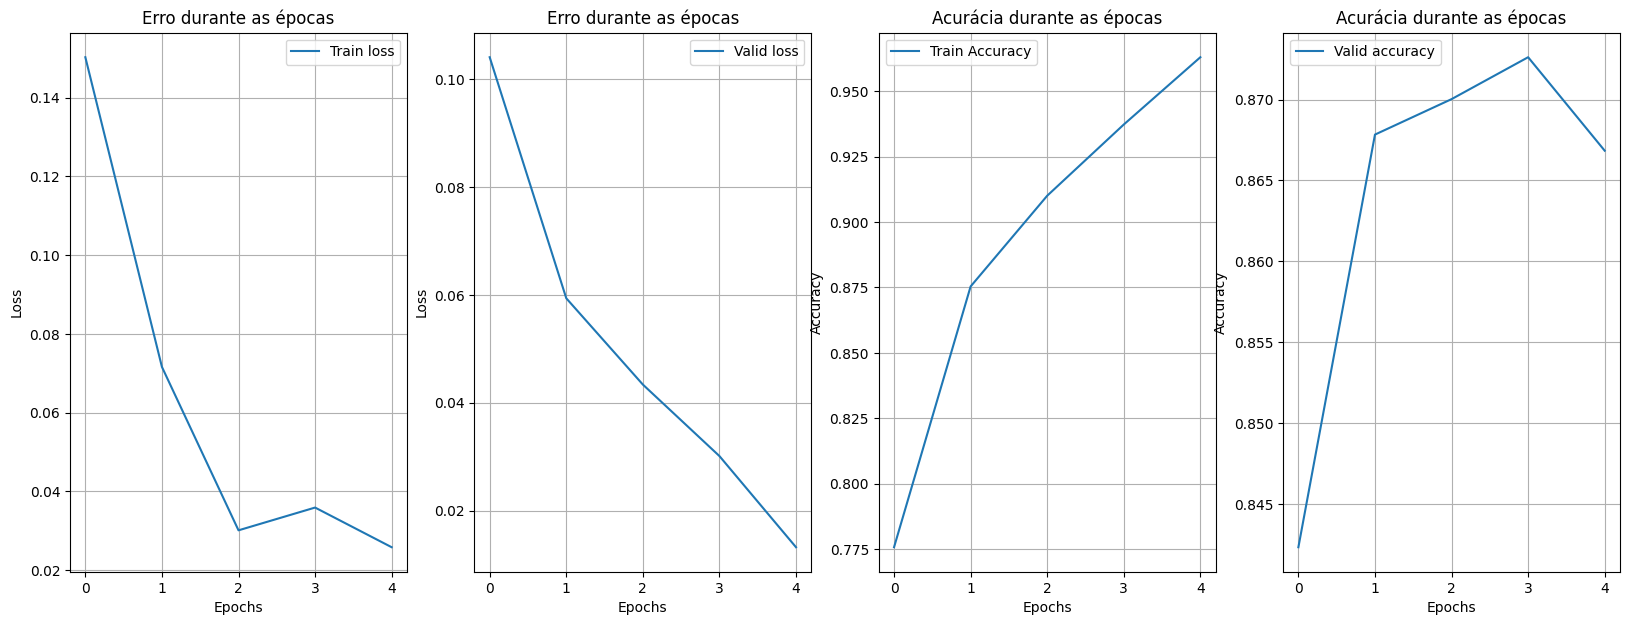

In [ ]:

def plot(history):


  train_loss_cpu = []
  valid_loss_cpu = []
  train_acc_cpu = []
  valid_acc_cpu = []

  for data in history['train_loss']:
    train_loss_cpu.append(data.data.cpu())
  for data in history['valid_loss']:
    valid_loss_cpu.append(data.data.cpu())
  for data in history['train_acc']:
    train_acc_cpu.append(data.data.cpu())
  for data in history['valid_acc']:
    valid_acc_cpu.append(data.data.cpu())

  fig, ax = plt.subplots(1, 4, figsize=(20,7))

  ax[0].plot(train_loss_cpu, label='Train loss')
  ax[1].plot(valid_loss_cpu, label='Valid loss')
  ax[2].plot(train_acc_cpu, label='Train Accuracy')
  ax[3].plot(valid_acc_cpu, label='Valid accuracy')


  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Erro durante as épocas')
  ax[0].legend()
  ax[0].grid()

  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].set_title('Erro durante as épocas')
  ax[1].legend()
  ax[1].grid()

  ax[2].set_xlabel('Epochs')
  ax[2].set_ylabel('Accuracy')
  ax[2].set_title('Acurácia durante as épocas')
  ax[2].legend()
  ax[2].grid()

  ax[3].set_xlabel('Epochs')
  ax[3].set_ylabel('Accuracy')
  ax[3].set_title('Acurácia durante as épocas')
  ax[3].legend()
  ax[3].grid()


  plt.show()

plot(history)

In [ ]:
def prediction(criterion,optimizer):
    # batch accumulation parameter
  correct_predictions = 0
  accum_iter = 4
  idx = 0

  predictions = []
  targets = []

  # loop through enumaretad batches
  for batch_idx, loader in enumerate(test_loader):

      # extract inputs and labels
      input_ids = loader["input_ids"].to(device)
      attention_mask = loader["attention_mask"].to(device)
      labels = loader["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      # passes and weights update
      with torch.set_grad_enabled(False):

          # forward pass
          _, preds = torch.max(outputs.logits, dim=1)
          loss  = criterion(outputs.logits, labels)

          # normalize loss to account for batch accumulation
          loss = loss / accum_iter

          correct_predictions += torch.sum(preds == labels)
          predictions.append(preds)
          targets.append(labels)
          idx+=1

  acc = correct_predictions/(params['batch_size']*idx)

  return loss, acc, predictions, targets

#### Evaluate in Test set

In [ ]:
## --- Insert code here --- ##
model = BertForSequenceClassification.from_pretrained(params['bert_version'])
model.load_state_dict(early_stopping.best_model_wts)
model.to(device)

loss, acc, preds, targets = prediction(criterion,optimizer)




Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

tensor(0.8728, device='cuda:0')


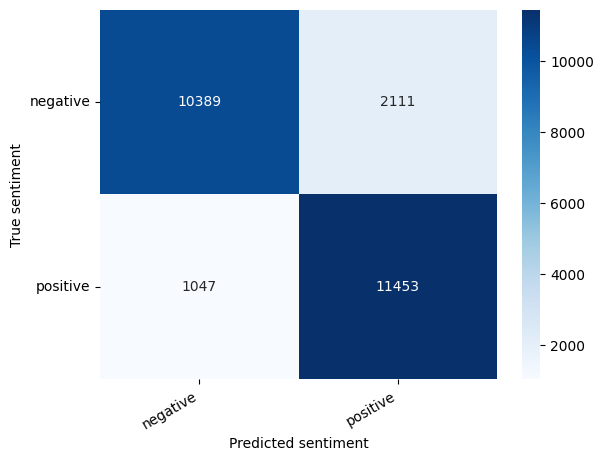

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

preds_general = []
targets_general = []

for data in preds:
  for pred in data.data.cpu():
    preds_general.append(pred)

for data in targets:
  for target in data.data.cpu():
    targets_general.append(target)

class_names = ['negative', 'positive']

cm = confusion_matrix(targets_general, preds_general)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

print(acc)

> What is your conclusions?

Ao longo do procedimento treinamento, foram feitas tentativas de usos de diversos modelos pré-treinados do BERT. Porém, modelos mais complexos acabavam por esgotar os recursos computacionais disponíveis. Assim, optou-se pelo uso de uma versão mais simplificada. Mesmo utilizando esse modelo mais simples pré-treinado do BERT e com uma quantidade não tão grande de dados, foi possível atingir uma acurácia consideravelmente boa de 87% no conjunto de teste.

Analisando a matriz de confusão acima, observa-se que o modelo treinado apresenta um melhor desempenho para classificar sentimentos positivos, enquanto o maior número de erros está na predição de falsos positivos. Ou seja, os erros do modelo estão mais caracterizados pela classificação de textos negativos como positivos. Isso pode ocorrer, por exemplo, devido a particularidades dos textos do conjunto de treino extraído do dataset.

De maneira geral, dada a simplicidade do modelo treinado, pode-se considerar que os resultados apresentados são satisfatórios, especialmente se compararmos o desempenho apresentado com o de um modelo aleatório. Nesse caso, em que há uma classificação binária de sentimento, a acurácia esperada de um modelo aleatório seria de 50%, enquanto o treinamento realizado conseguiu levar a acurácia para 87%. Muito provavelmente seria possível melhorar esse desempenho modificando alguns parâmetros de treinamento, como a versão do BERT utilizada, aumentando épocas ou o número de dados utilizados, porém, para os fins dessa atividade, os resultados obtidos foram suficientes para o aprendizado, além de o modelo ainda apresentar um bom desempenho. Com isso, foi possível exercitar os procedimentos e a pipeline de treinamento de um modelo de transformer.

## **Translation task**

In Natural Language Processing (NLP), translation tasks involve converting text from one language to another. The Paracrawl dataset, a valuable resource for translation research, consists of parallel text data gathered from various websites, enabling the development and training of translation models.


The T5 (Text-To-Text Transfer Transformer) deep learning model is a versatile language model that excels at various NLP tasks. It operates on the principle of transforming input text into output text, making it a powerful tool for tasks such as text summarization, translation, question answering, and more. T5 achieves this flexibility by formulating different tasks as text generation problems, which enables it to be fine-tuned on specific tasks while leveraging its pre-trained knowledge.

![t5_model](https://drive.google.com/uc?export=view&id=1h8tTSHIwkTon5j2WkBZBr7j731mWtL4O)

**Original paper:** *RAFFEL, Colin et al. Exploring the limits of transfer learning with a unified text-to-text transformer. The Journal of Machine Learning Research, v. 21, n. 1, p. 5485-5551, 2020.*


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
!pip install transformers sentencepiece torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 129.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 96.6 MB/s eta 0:00:00
CPU times: user 81 ms, sys: 8.34 ms, total: 89.3 ms
Wall time: 12.6 s


### Imports and global variables

In [ ]:
import re
import copy
import gzip
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import T5Tokenizer, T5ForConditionalGeneration

from typing import Dict
from typing import List
from typing import Tuple

In [ ]:
# Important: Fix seeds so we can replicate results
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


### Parameters

In [ ]:
params = {
    'model_name': 'unicamp-dl/ptt5-small-portuguese-vocab',
    'batch_size': 64,
    'accumulate_grad_batches': 4,
    'source_max_length': 128, # Maximum number of tokens in the source sentence (you can select a different value)
    'target_max_length': 128, # Maximum number of tokens in the target sentence (you can select a different value)
    'learning_rate': 1e-3,
    'evaluate_interval': 500  # Intervals at which we will evaluate the model (in steps)
}

### Load data

Here we are loading the data. Notice that the label no longer consists of a class index, but instead, it comprises a complete sentence. In the modified Paracrawl dataset, the input sentence is in English, while the output sentence is in Portuguese.

For training, we will use 99k samples, 10k samples for validation, and 20k samples for testing.

**Note:** If you are experiencing issues with GPU allocation, you can reduce the number of training samples. Otherwise, it is advisable to utilize the entire dataset.

LINK TO THE [DATASET](https://drive.google.com/drive/folders/1tUwgkpcLXAsZizXUKfJeN5ZH75rEj3Js?usp=sharing)

In [ ]:
def load_text_pairs(path):
    text_pairs = []
    for line in gzip.open(path, mode='rt'):
        text_pairs.append(line.strip().split('\t'))
    return text_pairs

x_train = load_text_pairs('drive/MyDrive/NLP_Datasets/paracrawl_en_pt_train.tsv.gz')
x_test  = load_text_pairs('drive/MyDrive/NLP_Datasets/paracrawl_en_pt_test.tsv.gz')

random.shuffle(x_train)

x_valid = x_train[990000:]
x_train = x_train[:990000]

print('\nFirst three train samples:')
for i, (source, target) in enumerate(x_train[:3]):
  print(f'{i}: source: {source}\n   target: {target}\n')

print('-'*200)
print('\nFirst three valid samples:')
for i, (source, target) in enumerate(x_valid[:3]):
  print(f'{i}: source: {source}\n   target: {target}\n')

print('-'*200)
print(f'Train size: {len(x_train)}')
print(f'Valid size: {len(x_valid)}')
print(f'Test size: {len(x_test)}')


First three train samples:
0: source: The ECOWAS Member states are as follows:
   target: Os Estados-membros da CEDEAO são:

1: source: May our Movement, which the Spirit of Christ has aroused and brought about in obedience and in peace, fraternally inspire the whole of Christian society, so that in all the places where the faith is proclaimed there may be found traces of Mary’s holiness (“In you is mercy, in you pity, in you munificence, in you is found whatever of goodness is in any creature”).
   target: Nosso movimento, que o Espírito de Cristo despertou e realizou dentro da obediência e da paz, inspire fraternalmente toda a sociedade cristã, de modo a que em todos os lugares onde a fé for proclamada possam ser encontrados vestígios da santidade de Nossa Senhora (“Em ti, misericórdia, em ti, piedade,/ em ti magnificência, em ti se coaduna/ todo o bem que existe nas criaturas”).

2: source: Lying 11 km from Żelazowa Wola there is Brochów with its imposing brick parish church where 

### Class Dataset from PyTorch.

When training a T5 model for a translation task, the dataset should be structured in a way that includes pairs of source (input) sentences and target (output) sentences. Each pair represents a translation example.

Here's an example of how the dataset can be structured:
```
  {"source": "I like cats.", "target": "Eu gosto de gatos."},
  {"source": "The sun is shining.", "target": "O sol está brilhando."},
  {"source": "She speaks French.", "target": "Ela fala francês."},
    ...
```

In this structure, each example is a dictionary with two keys: "source" and "target". The value for the "source" key represents the input sentence in the source language (e.g., English), and the value for the "target" key represents the corresponding translation sentence in the target language (e.g., Portuguese).

During the training process, you would load this dataset into your custom PyTorch dataset class, preprocess the sentences (e.g., tokenization), and convert them into model-specific inputs and targets using a tokenizer (such as the [T5Tokenizer](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5Tokenizer) provided by Hugging Face).


**Hint 1:** See the [Dataset and Dataloader documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information.

In [ ]:
class ParacrawlDataset(Dataset):
  def __init__(self, text_pairs: List[Tuple[str]], tokenizer, source_max_length: int = 32, target_max_length: int = 32):
    self.text_pairs        = text_pairs
    self.tokenizer         = tokenizer
    self.source_max_length = source_max_length
    self.target_max_length = target_max_length


  def __len__(self):
    return len(self.text_pairs)

  def __getitem__(self, index):
    source, target = self.text_pairs[index]

    source_tokens = self.tokenizer(source, add_special_tokens=True,
                                    max_length=self.source_max_length,
                                    padding="max_length",
                                    truncation=True,
                                    return_tensors='pt')

    target_tokens = self.tokenizer(target, add_special_tokens=True,
                                    max_length=self.target_max_length,
                                    padding="max_length",
                                    truncation=True,
                                    return_tensors='pt')

    source_token_ids = source_tokens['input_ids'][0]
    source_mask      = source_tokens['attention_mask'][0]
    original_source  = source

    target_token_ids = target_tokens['input_ids'][0]
    target_mask      = target_tokens['attention_mask'][0]
    original_target  = target

    ## The output should return variables representing the following information:
      # source_token_ids : The source sentence converted into tokens.
      # source_mask      : The source mask attention.
      # target_token_ids : The target sentence converted into tokens.
      # target_mask      : The target mask attention.
      # original_source  : Original source sentence without preprocess nor tokenization.
      # original_target  : Original target sentence without preprocess nor tokenization.

    return (source_token_ids, source_mask, target_token_ids, target_mask, original_source, original_target)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained(params['model_name'])

dataset_train = ParacrawlDataset(text_pairs=x_train, tokenizer=tokenizer, source_max_length=params['source_max_length'], target_max_length=params['target_max_length'])
dataset_valid = ParacrawlDataset(text_pairs=x_valid, tokenizer=tokenizer, source_max_length=params['source_max_length'], target_max_length=params['target_max_length'])
dataset_test  = ParacrawlDataset(text_pairs=x_test,  tokenizer=tokenizer, source_max_length=params['source_max_length'], target_max_length=params['target_max_length'])

train_loader = DataLoader(dataset_train, batch_size=params['batch_size'], shuffle=True,  num_workers=0)
valid_loader = DataLoader(dataset_valid, batch_size=params['batch_size'], shuffle=False, num_workers=0)
test_loader  = DataLoader(dataset_test,  batch_size=params['batch_size'], shuffle=False, num_workers=0)

### Useful functions

**Note 1:** The following functions are provided as suggestions. You are free to modify and create your own functions, classes, or code. Feel free to customize!

**Note 2:** Example of gradient accumalation in PyTorch: https://kozodoi.me/blog/20210219/gradient-accumulation.

**Note 3:** The training step function consists of just one iteration, not one epoch.

In [ ]:
def train_step():
  ## --- Insert code here --- ##
  return None

def evaluate(model, dataloader, mode='loss'):
  ## --- Insert code here --- ##
  return None

In [ ]:
class EarlyStopping():
  '''
    Early stopping prevents overfitting by stopping the training process when
    the model's performance on a validation set starts to worsen.

    Parameters:
    -----------
    patience  : int
      Tolerance for no improvement.
    min_delta : float
      Minimum change required.
  '''

  def __init__(self, patience=1, min_delta=0.0001):
    self.patience = patience
    self.counter = 0
    self.best_score = None
    self.best_model_wts = None
    self.min_delta = min_delta

  def __call__(self, model, val_loss):
    score = -val_loss

    if self.best_score is None:
      self.best_score = score
      self.best_model_wts = copy.deepcopy(model.state_dict())
      return False

    elif score < self.best_score + self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        return True
    else:
      self.best_score = score
      self.best_model_wts = copy.deepcopy(model.state_dict())
      self.counter = 0
    return False

### Train the T5 model

**Note:** The following functions are provided as suggestions. You are free to modify and create your own functions, classes, or code. Feel free to customize!

**Hint 1:** See the [T5ForConditionalGeneration documentation](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5ForConditionalGeneration) for more information.

**Hint 2:** Instead of saving information by epoch, you can save it by step. A step corresponds to a single update of the model's weights based on a mini-batch of data, while an epoch represents a complete pass through the entire training dataset. The number of steps is determined by the batch size and the total number of training examples, whereas the number of epochs is a user-defined hyperparameter.

**Hint 3:** You don't need to train for an entire epoch, as that would take 4 hours. Instead, you can train for around 2000 steps and evaluate the model. Although the model may not be optimal, it provides a good approximation.

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(params['model_name'])
model = model.to(device)

optimizer = None
scheduler = None

early_stopping = EarlyStopping()

history = {'train_loss': [], 'val_loss': []}
epoch = 1

while True:
  for batch_idx, data in enumerate(tqdm(train_loader, total=len(train_loader), desc=f'Training step')):
    train_loss = train_step()
    history['train_loss'].append(train_loss)

    if ((batch_idx + 1) % params['evaluate_interval'] == 0):
        val_loss = evaluate()

        history['val_loss'].append(val_loss)
        if early_stopping(model=model, val_loss=val_loss): break

  epoch += 1

### Evaluation of the model

In [ ]:
## Save Best Model Weights and history
path = 'drive/MyDrive'
torch.save(early_stopping.best_model_wts, f'{path}/weights_T5.pth')

np.save(f'{path}/train_loss_T5', np.array(history['train_loss']))
np.save(f'{path}/valid_loss_T5', np.array(history['valid_loss']))

np.save(f'{path}/train_acc_T5', np.array(history['train_acc']))
np.save(f'{path}/valid_acc_T5', np.array(history['valid_acc']))

In [ ]:
## Load
train_loss = np.load(f'{path}/train_loss_T5.npy')
train_acc  = np.load(f'{path}/train_acc_T5.npy')

valid_loss = np.load(f'{path}/valid_loss_T5.npy')
valid_acc  = np.load(f'{path}/valid_acc_T5.npy')

#### Plot the Train and Valid loss (in Steps)

In [ ]:
## --- Insert code here --- ##
plot(history)

#### Calculate the BLEU Score

[BLEU](https://en.wikipedia.org/wiki/BLEU) (Bilingual Evaluation Understudy) is a metric that measures the similarity between machine-generated translations and reference translations.

**Hint 1:** There are many libraries that have already implemented the BLEU score, such as [torchmetrics](https://torchmetrics.readthedocs.io/en/latest/). You DON'T have to implement it yourself.

In [ ]:
## --- Insert code here --- ##
def calculate_blue_score():
  return None

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(params['model_name'])
model.load_state_dict(early_stopping.best_model_wts)
model.to(device)

valid_blue_score = calculate_blue_score()
test_blue_score  = calculate_blue_score()

print(f'Validation BLUE: {valid_blue_score}')
print(f'Test BLUE: {test_blue_score}')

#### Implement a function that translates an English sentence to Portuguese.

**Hint 1:** See the documentation of [T5ForConditionalGeneration](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5ForConditionalGeneration).

**Hint 2:** Remember to decode the feature generated by the model using the [T5Tokenizer](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5Tokenizer)

In [ ]:
def translate():
## --- Insert code here --- ##
  return None

In [ ]:
sample = None
translate(sample)

> What is your conclusion?